# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
# import statements
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from tqdm.notebook import tqdm, trange
import time
import datetime
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection, metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from collections import Counter
import datetime
from sklearn.feature_selection import SelectFromModel
from sklearn import feature_selection
from sklearn import model_selection, metrics
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:

# read the json files
portfolio = pd.read_json('/Users/doyindav/Desktop/data science/udacity_capstone/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/Users/doyindav/Desktop/data science/udacity_capstone/profile.json', orient='records', lines=True)
transcript = pd.read_json('/Users/doyindav/Desktop/data science/udacity_capstone/transcript.json', orient='records', lines=True)


### 1. Data Exploration 

* **View the read in dataFrames**

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* **Check the shape of the dataframe**

In [6]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

* **Check if there are null values in the dataframe**

In [7]:
portfolio.isnull().sum()/profile.shape[0]

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [8]:
transcript.isnull().sum()/transcript.shape[0]

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [9]:
profile.isnull().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

About 13% of gender and income columns are null values. Let's investigate the null values

In [10]:
profile[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


The age corressponding to the null values is 118. Let's check all the values where age = 118

In [11]:
profile[profile['age']==118]['gender'].sum(), profile[profile['age']==118]['income'].sum()

(0, 0.0)

**Where age = 118, all gender and income values are null. Since the number of NaN values are consistent in the 
gender and income columns, we can drop the NaNs. As this is user-specific data, assigning values to the NaNs 
would be erroneous**

In [12]:
# drop the NaN values
profile = profile.dropna(axis=0, how='any')

# change became_member_on column to proper date format
profile.loc[:, 'became_member_on'] = profile['became_member_on'].astype(str)
profile = profile.assign(became_member_on = pd.to_datetime(profile['became_member_on']))
profile[['year_joined']] = profile['became_member_on'].dt.year
profile[['month_joined']] = profile['became_member_on'].dt.month


profile.head()

,gender,age,id,became_member_on,income,year_joined,month_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [13]:
profile = profile.rename(columns={'id':'customer_id'})
profile.head()

,gender,age,customer_id,became_member_on,income,year_joined,month_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


**Data Wrangling on transcript dataframe**

In [14]:
# explore the transcript data
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
# value column has two types of enteries, offer id and amount
def clean_transcript(df):
    """
    Cleans the transcript dataframe
    
    INPUT:
    df - dataframe
    
    OUTPUT
    cleaned transcript dataframe
    
    """
    for i in range(len(df['value'])):
        
        if (list(df.loc[i,'value'].keys())[0] == 'offer_id') | (list(df.loc[i, 'value'].keys())[0] == 'offer id'):
        
           df.loc[i, "offer_id"]= list(df.loc[i, 'value'].values())[0]
        
        elif list(df.loc[i, 'value'].keys())[0] == 'amount':
        
           df.loc[i, "amount"] = list(df.loc[i, 'value'].values())[0]
    
        
    # Drop the original value column
    df = df.drop(['value'], axis=1)
    
    
    return df

In [16]:
transcript = clean_transcript(transcript)
transcript.head()

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [17]:
transcript.shape

(306534, 5)

In [18]:
# since the time is in hours, we should change it to days to make it more meaningful
transcript['time_days'] = transcript['time']/24

#drop the original time column
transcript = transcript.drop('time', axis=1)

# Get dummy variables for the event column
event_dummy = pd.get_dummies(transcript['event'])

# concatenate wwith the trasnscript dataframe
transcript = pd.concat([transcript, event_dummy], axis=1)

# rename the person column
transcript = transcript.rename(columns={'person':'customer_id'})

transcript.head()

,customer_id,event,offer_id,amount,time_days,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,NaN,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0.0,0,1,0,0


**Data Wrangling on the Portfolio dataframe**

In [19]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [20]:
def clean_channels(df):
    """
    Expands the channels column in the df
    
    INPUT:
    df - dataframe
    
    OUTPUT
    cleaned portfolio dataframe with columns from channels
    
    """
    items = ['web', 'email', 'social', 'mobile']
    
    for channel in items:
        df[channel] = df['channels'].apply(lambda x: channel in x) * 1
        
    # delete the original channels column
    # delete the channels column
    df = df.drop('channels', axis=1)

    return df

In [21]:
portfolio = clean_channels(portfolio)
portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [22]:
# Create dummy variables for thee offer_type column and rename the 'id' column to 'offer_id'

offer_dummy = pd.get_dummies(portfolio['offer_type'])

portfolio = pd.concat([portfolio, offer_dummy], axis=1)

# rename the 'id' column to 'offer_id'
portfolio = portfolio.rename(columns={'id':'offer_id'})

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### 2. Merge the three (3) datasets 

In [23]:
# merge profile and transcript dataframes
profile_transcript = profile.merge(transcript, how='left', on='customer_id')

# merge the resultant dataframe with the portfolio dataframe
merged_df = profile_transcript.merge(portfolio, how='left', on='offer_id')

merged_df.head()

,gender,age,customer_id,became_member_on,income,year_joined,month_joined,event,offer_id,amount,...,difficulty,duration,offer_type,web,email,social,mobile,bogo,discount,informational
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,21.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,32.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,3f207df678b143eea3cee63160fa8bed,NaN,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,23.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **Before we investigate the merged dataframe, we have to create bins for age and income of the customers for** 
    **better analysis**

In [24]:
# create bins for income
labels = ['20k to 40k', '40k to 60k', '60k to 80k', '80k to 100k', '100k to 120k']
income_bins = pd.cut(merged_df['income'], bins = [20000, 40000, 60000, 80000, 100000, 120000], right=True, labels=labels)

# create bins for age
age_labels = ['0 to 20yrs', '20 to 40yrs', '40 to 60yrs', '60 to 80yrs', '80yrs to 100yrs', '100yrs to 120yrs']
age_bins = pd.cut(merged_df['age'], bins = [0, 20, 40, 60, 80, 100, 120], right=True, labels=age_labels)

# create dataframes from the age and income bins
age_cluster = pd.DataFrame(age_bins).rename(columns={'age':'age_cluster'})
income_cluster = pd.DataFrame(income_bins).rename(columns={'income':'income_cluster'})

# add age and income clusters to the merged dataframe
merged_df = pd.concat([merged_df, age_cluster], axis=1)
merged_df = pd.concat([merged_df, income_cluster], axis=1)

merged_df.head(10)

,gender,age,customer_id,became_member_on,income,year_joined,month_joined,event,offer_id,amount,...,offer_type,web,email,social,mobile,bogo,discount,informational,age_cluster,income_cluster
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,21.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,32.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,40 to 60yrs,100k to 120k
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,3f207df678b143eea3cee63160fa8bed,NaN,...,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,40 to 60yrs,100k to 120k
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,23.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k
5,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,40 to 60yrs,100k to 120k
6,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,60 to 80yrs,80k to 100k
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,60 to 80yrs,80k to 100k
8,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,transaction,NaN,19.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60 to 80yrs,80k to 100k
9,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,60 to 80yrs,80k to 100k


In [25]:
merged_df.shape

(272762, 28)

* **Save merged dataframe as pickle**

In [26]:
# save as pickle
merged_df.to_pickle('/Users/doyindav/Desktop/data science/merged_df.pkl')

### 3. Data Visualisations on the merged dataset 

In [27]:
# read in the pickle file
df = pd.read_pickle("/Users/doyindav/Desktop/data science/merged_df.pkl")
df.head()

,gender,age,customer_id,became_member_on,income,year_joined,month_joined,event,offer_id,amount,...,offer_type,web,email,social,mobile,bogo,discount,informational,age_cluster,income_cluster
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,21.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,32.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,40 to 60yrs,100k to 120k
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,offer received,3f207df678b143eea3cee63160fa8bed,NaN,...,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,40 to 60yrs,100k to 120k
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,transaction,NaN,23.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40 to 60yrs,100k to 120k


* What is the distribution of age and income within the dataset

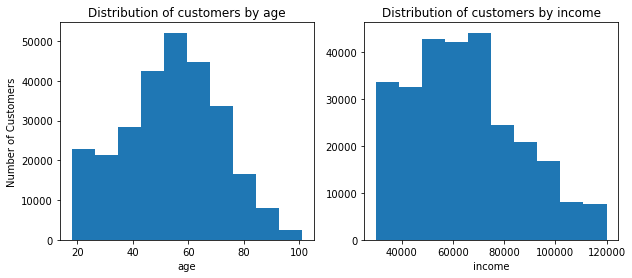

In [28]:
# Distribution of age and income in the dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(df['age']);
ax2.hist(df['income']);

ax1.set_xlabel('age');
ax2.set_xlabel('income');
ax1.set_ylabel('Number of Customers');


ax1.set_title('Distribution of customers by age');
ax2.set_title('Distribution of customers by income');

1. More of the customers in the dataset are between 50-60 years.
2. Majority of the customers are in the 40 to 70k income bracket


In [29]:
print('The average age of starbucks customers in the dataset is {} years'.format(round(df['age'].mean())))

print('50% of the starbucks customers in the dataset are less than {} years old'.format(round(df['age'].median())))


The average age of starbucks customers in the dataset is 54 years
50% of the starbucks customers in the dataset are less than 55 years old


In [30]:
print('The average income of starbucks customers in the dataset is {}k'.format(round(df['income'].mean())))

print('50% of the starbucks customers in the dataset are less than {}k'.format(round(df['income'].median())))


The average income of starbucks customers in the dataset is 64337k
50% of the starbucks customers in the dataset are less than 62000k


**What is the distribution of gender in the dataset?**

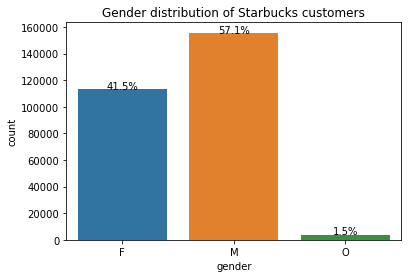

In [31]:
bx = sb.countplot(data = df, x='gender');

total = float(df['gender'].count())
for p in bx.patches:
    width = p.get_width()
    height = p.get_height()
    bx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
bx.set_title('Gender distribution of Starbucks customers');

Male members of the Starbucks rewards program account for **57%** of total customers while female members
account for **41.5%** while people who do not identify as either male or female make up the remaining **15%**.

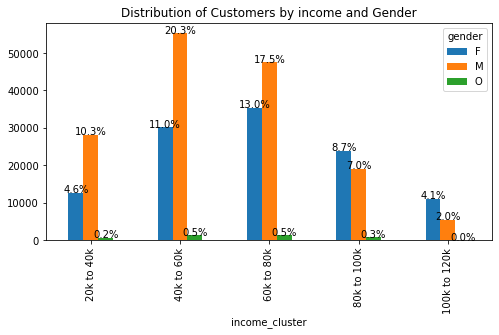

In [32]:
cx = pd.crosstab(df['income_cluster'], df['gender']).plot(kind='bar', figsize=(8,4))

cx

total = float(df['income_cluster'].count())
for p in cx.patches:
    width = p.get_width()
    height = p.get_height()
    cx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
cx.set_title('Distribution of Customers by income and Gender');

 In income brackets that represent our most popular customers, men out earn women by about **7%** in 40-60k, and by **4.5%** in 60 to 80k. The differences reduce in higher icome brackets, 80k - 120k.  

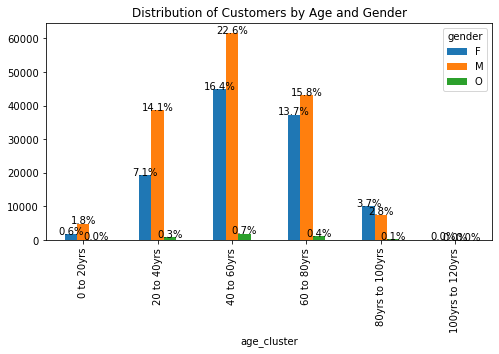

In [33]:
dx = pd.crosstab(df['age_cluster'], df['gender']).plot(kind='bar', figsize=(8,4))
#bx = ax.div(ax.sum(1), axis=0)
dx

total = float(df['gender'].count())
for p in dx.patches:
    width = p.get_width()
    height = p.get_height()
    dx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
dx.set_title('Distribution of Customers by Age and Gender');

Men are also generally older than women in the different age bins 

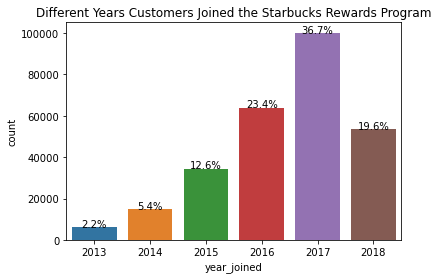

In [34]:
ex = sb.countplot(data=df, x='year_joined');

total = float(df['year_joined'].count())
for p in ex.patches:
    width = p.get_width()
    height = p.get_height()
    ex.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
ex.set_title('Different Years Customers Joined the Starbucks Rewards Program');

Customer Particpation of The Starbucks rewards program has seen year on year increase. 2017 is the best year
so far with 36.75% of customers having joined in 2017. The data for 2018 stops at July, as such the plot shows a reduction for 2018. 

In [35]:
df.groupby(['year_joined'])['month_joined'].max()

year_joined
2013    12
2014    12
2015    12
2016    12
2017    12
2018     7
Name: month_joined, dtype: int64

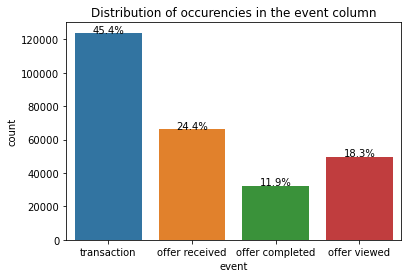

In [36]:
# Distribution of occurencies in the events folder
fx = sb.countplot(data=df, x='event');

total = float(df['event'].count())
for p in fx.patches:
    width = p.get_width()
    height = p.get_height()
    fx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
fx.set_title('Distribution of occurencies in the event column');

### 4. Create a dataframe of all offers sent to each customer

In [37]:
df_extract = df.copy()

In [38]:
def offers_grouped(df):
    """
    This function groups all customers by all offer_ids sent to them and creates columns that ascribe time 
    to activities, i.e offer received time, offer viewed time. 
    
    INPUT:
    df - dataframe
    
    OUTPUT
    grouped dataframe by customer_id and offer_id, with addidtional time columns. 
    
    """    
    # replace time = 0 with time=0.05 (a number close to zero) to differentiate it with no-event time
    df['time_days'] = df['time_days'].replace(0, 0.05)
        
    # create columns for time offers were received, viewed and completed
    df['offer received time'] = df['offer received'] * df['time_days']
    df['offer viewed time'] = df['offer viewed'] * df['time_days']
    df['offer completed time'] = df['offer completed'] * df['time_days']
        
    # create an offer end time to know when the offers expire
    df['offer end time'] = df['offer received time'] + df['duration']
        
    # create a df of all offers sent to each customers
    df = df.groupby(['customer_id', 'offer_id']).agg(lambda x: x.max())
        
    # reset the index
    df = df.reset_index()
        
    # making the offer completed time for informational offers as the offer end time
    df['offer completed time'] = np.where(df['offer_type']== 'informational', df['offer end time'], df['offer completed time'])

    # check if the offers are viewed before they end and they are completed after being viewed and before they end
    df.loc[(df['offer viewed time'] < df['offer end time']), 'viewed on time']=1

    df.loc[(df['offer completed time'] > df['offer viewed time']) & (df['offer completed time'] <= df['offer end time']), 'completed_on_time']=1

    # fill up the NaNs with '0'
    df['completed_on_time'] = df['completed_on_time'].fillna(0)
    df['viewed on time'] = df['viewed on time'].fillna(0)
    
    return df
        

In [39]:
df_grouped = offers_grouped(df_extract)
df_grouped.head()

,customer_id,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,amount,...,discount,informational,age_cluster,income_cluster,offer received time,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,NaN,...,1.0,0.0,20 to 40yrs,60k to 80k,24.0,0.0,24.00,31.0,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,0.0,1.0,20 to 40yrs,60k to 80k,14.0,15.5,18.00,18.0,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,0.0,1.0,20 to 40yrs,60k to 80k,7.0,8.0,10.00,10.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,0.0,0.0,20 to 40yrs,60k to 80k,17.0,19.0,17.25,22.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,1.0,0.0,20 to 40yrs,60k to 80k,21.0,22.5,22.00,31.0,1.0,0.0


**How we do acsertain if informational offers have been completed?**

The assumption is that customers who have viewed an informational offer are under the influence of the offer throughout its validity period.

we need to look for transactions carried out during the validity period and check that the amount tallies.

In [40]:
# Extract the informational offers
inform_offers = df_grouped[df_grouped['offer_type']=='informational']

# Extract the viewed informational offers
view_inform_offers = inform_offers[inform_offers['offer viewed']==1]
        
# extract all transaction details where customers did not receive any offers
transaction_df = df_extract[df_extract['transaction']==1]

#create a transaction_df with customer_ids where informational offers were viewed
cust_list = view_inform_offers['customer_id']
new_transaction_df = transaction_df[transaction_df['customer_id'].isin(cust_list)]

In [41]:
# check if amount spent equals or is greater than offer difficulty
for i in tqdm(new_transaction_df['amount']):
        
    df_grouped['inform_amount'] = (i >= view_inform_offers['difficulty'])
    
    df_grouped['inform_amount'] = df_grouped['inform_amount'] * 1
    
    df_grouped['inform_amount'] = df_grouped['inform_amount'].fillna(0)        

In [42]:
# check if the transaction was done within the offer's validity
for j in tqdm(new_transaction_df['time_days']):
        
    df_grouped['inform_time'] = (j < view_inform_offers['time_days'])
    
    df_grouped['inform_time'] = df_grouped['inform_time'] * 1
    
    df_grouped['inform_time'] = df_grouped['inform_time'].fillna(0)        

In [43]:
df_grouped.head()

,customer_id,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,amount,...,age_cluster,income_cluster,offer received time,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time,inform_amount,inform_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,NaN,...,20 to 40yrs,60k to 80k,24.0,0.0,24.00,31.0,1.0,1.0,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,20 to 40yrs,60k to 80k,14.0,15.5,18.00,18.0,1.0,1.0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,20 to 40yrs,60k to 80k,7.0,8.0,10.00,10.0,1.0,1.0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,20 to 40yrs,60k to 80k,17.0,19.0,17.25,22.0,1.0,0.0,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,NaN,...,20 to 40yrs,60k to 80k,21.0,22.5,22.00,31.0,1.0,0.0,0,0


In [44]:
# informational offer is complete if both 'inform_amount and inform_time' =1
df_grouped.loc[(df_grouped['inform_amount']==1) & (df_grouped['inform_time']==1), 'inform_complete']=1

# Fill the NaN values with 0 
df_grouped['inform_complete'] = df_grouped['inform_complete'].fillna(0)

df_grouped['viewed on time'] = np.where(df_grouped['offer viewed time']== 0.0, df_grouped['offer viewed time'], df_grouped['viewed on time'])

df_grouped['completed_on_time'] = np.where(df_grouped['viewed on time']==0, df_grouped['viewed on time'], df_grouped['completed_on_time'])

df_grouped['completed_on_time'] = np.where(df_grouped['offer_type']=='informational', df_grouped['inform_complete'], df_grouped['completed_on_time'])


In [45]:
df_grouped = df_grouped.drop(['amount'], axis=1)

* Create a new column offer_successful

In [46]:
# if an offer is completed on time, it is successful
df_grouped.loc[df_grouped['completed_on_time']==1, 'offer_successful']=1

# Fill in the NaN values
df_grouped['offer_successful'] = df_grouped['offer_successful'].fillna(0)

df_grouped.head()

,customer_id,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,time_days,...,offer received time,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time,inform_amount,inform_time,inform_complete,offer_successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,24.0,...,24.0,0.0,24.00,31.0,0.0,0.0,0,0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,15.5,...,14.0,15.5,18.00,18.0,1.0,0.0,1,0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,8.0,...,7.0,8.0,10.00,10.0,1.0,0.0,1,0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,19.0,...,17.0,19.0,17.25,22.0,1.0,0.0,0,0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,22.5,...,21.0,22.5,22.00,31.0,1.0,0.0,0,0,0.0,0.0


**Add the total amount customers have spent to df_grouped**

In [47]:
# Sum up the money customers have spent 
amount_df = transaction_df.groupby('customer_id')['amount'].sum().reset_index()

# merge the amount_df dataframe to df_grouped 
new_grouped = amount_df.merge(df_grouped, how='right', on='customer_id')

In [48]:
df_grouped = new_grouped
df_grouped.head()

,customer_id,amount,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,...,offer received time,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time,inform_amount,inform_time,inform_complete,offer_successful
0,0009655768c64bdeb2e877511632db8f,127.6,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,...,24.0,0.0,24.00,31.0,0.0,0.0,0,0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,127.6,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,14.0,15.5,18.00,18.0,1.0,0.0,1,0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,127.6,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,7.0,8.0,10.00,10.0,1.0,0.0,1,0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,127.6,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,17.0,19.0,17.25,22.0,1.0,0.0,0,0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,127.6,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,21.0,22.5,22.00,31.0,1.0,0.0,0,0,0.0,0.0


In [49]:
# some customers have not spent any money, so replace NaN's with 0 
df_grouped['amount'] = df_grouped['amount'].fillna(0)

# rename 'amount' column to 'amount spent'
df_grouped = df_grouped.rename(columns={'amount': 'amount_spent'})

# Add a cluster for amount spent
labels = ['0 to 100', '100 to 200', '200 to 300', '300 to 400', ' 400 to 500', '500 to 2000']
amount_bins = pd.cut(df_grouped['amount_spent'], bins = [-np.inf, 100, 200, 300, 400, 500, 2000], right=True,
                     labels=labels, include_lowest=True)


amount_spent_cluster = pd.DataFrame(amount_bins).rename(columns={'amount_spent': 'amount_cluster'})

amount_concat = pd.concat([df_grouped, amount_spent_cluster], axis=1)

df_grouped = amount_concat

df_grouped.head()

,customer_id,amount_spent,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,...,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time,inform_amount,inform_time,inform_complete,offer_successful,amount_cluster
0,0009655768c64bdeb2e877511632db8f,127.6,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,...,0.0,24.00,31.0,0.0,0.0,0,0,0.0,0.0,100 to 200
1,0009655768c64bdeb2e877511632db8f,127.6,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,15.5,18.00,18.0,1.0,0.0,1,0,0.0,0.0,100 to 200
2,0009655768c64bdeb2e877511632db8f,127.6,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,8.0,10.00,10.0,1.0,0.0,1,0,0.0,0.0,100 to 200
3,0009655768c64bdeb2e877511632db8f,127.6,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,19.0,17.25,22.0,1.0,0.0,0,0,0.0,0.0,100 to 200
4,0009655768c64bdeb2e877511632db8f,127.6,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,22.5,22.00,31.0,1.0,0.0,0,0,0.0,0.0,100 to 200


**What proportion of customers who received offers completed them?**

In [50]:
df_grouped['offer_successful'].sum()/df_grouped.shape[0]

0.3107819347361559

In [51]:
# Check for null values 
df_grouped.isnull().sum()

customer_id             0
amount_spent            0
offer_id                0
gender                  0
age                     0
became_member_on        0
income                  0
year_joined             0
month_joined            0
event                   0
time_days               0
offer completed         0
offer received          0
offer viewed            0
transaction             0
reward                  0
difficulty              0
duration                0
offer_type              0
web                     0
email                   0
social                  0
mobile                  0
bogo                    0
discount                0
informational           0
age_cluster             0
income_cluster          0
offer received time     0
offer viewed time       0
offer completed time    0
offer end time          0
viewed on time          0
completed_on_time       0
inform_amount           0
inform_time             0
inform_complete         0
offer_successful        0
amount_clust

In [52]:
# Save as pickle 
df_grouped.to_pickle('/Users/doyindav/Desktop/data science/df_grouped.pkl')

* Read in picke file 

In [53]:
df_grouped = pd.read_pickle('/Users/doyindav/Desktop/data science/df_grouped.pkl')
df_grouped.head()

,customer_id,amount_spent,offer_id,gender,age,became_member_on,income,year_joined,month_joined,event,...,offer viewed time,offer completed time,offer end time,viewed on time,completed_on_time,inform_amount,inform_time,inform_complete,offer_successful,amount_cluster
0,0009655768c64bdeb2e877511632db8f,127.6,2906b810c7d4411798c6938adc9daaa5,M,33,2017-04-21,72000.0,2017,4,offer received,...,0.0,24.00,31.0,0.0,0.0,0,0,0.0,0.0,100 to 200
1,0009655768c64bdeb2e877511632db8f,127.6,3f207df678b143eea3cee63160fa8bed,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,15.5,18.00,18.0,1.0,0.0,1,0,0.0,0.0,100 to 200
2,0009655768c64bdeb2e877511632db8f,127.6,5a8bc65990b245e5a138643cd4eb9837,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,8.0,10.00,10.0,1.0,0.0,1,0,0.0,0.0,100 to 200
3,0009655768c64bdeb2e877511632db8f,127.6,f19421c1d4aa40978ebb69ca19b0e20d,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,19.0,17.25,22.0,1.0,0.0,0,0,0.0,0.0,100 to 200
4,0009655768c64bdeb2e877511632db8f,127.6,fafdcd668e3743c1bb461111dcafc2a4,M,33,2017-04-21,72000.0,2017,4,offer viewed,...,22.5,22.00,31.0,1.0,0.0,0,0,0.0,0.0,100 to 200


* **Data Exploration and Visualizations on the grouped dataframe**

* What are the most popular offers sent out?
* How did customer demographics respond to the offers?

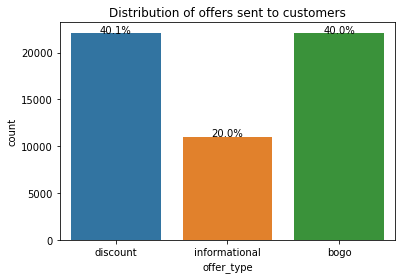

In [54]:
gx = sb.countplot(data=df_grouped, x ='offer_type');

total = float(df_grouped['offer_type'].count())
for p in gx.patches:
    width = p.get_width()
    height = p.get_height()
    gx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
gx.set_title('Distribution of offers sent to customers');

Discount and BOGO offers were sent out more than Informational offers

In [55]:
# Create a dataframe of successful offers
offer_success = df_grouped[df_grouped['offer_successful']==1]

# create a dataframe of successful offer_types
dis_success = offer_success[offer_success['offer_type']=='discount']
bogo_success = offer_success[offer_success['offer_type']=='bogo']
inform_success = offer_success[offer_success['offer_type']=='informational']

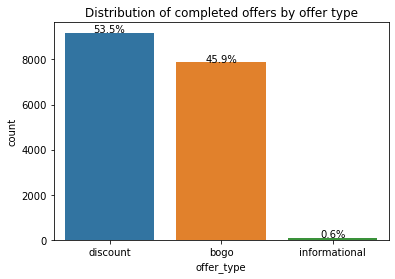

In [56]:
hx = sb.countplot(data=offer_success, x ='offer_type');

total = float(offer_success['offer_type'].count())
for p in hx.patches:
    width = p.get_width()
    height = p.get_height()
    hx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
hx.set_title('Distribution of completed offers by offer type');

**Discount** offers are the most popular offers completed
**Informational** offers were rarely completed with a completion rate of 0.6%, although they were shown 20% less 
than both BOGO and discount offers

### Customer demographics

1. **Income**

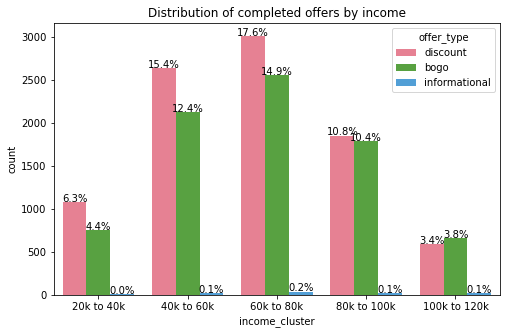

In [57]:
ix = plt.figure(figsize=(8, 5))
ix = sb.countplot(data = offer_success, x='income_cluster', hue='offer_type',
                 order =['20k to 40k', '40k to 60k', '60k to 80k', '80k to 100k', '100k to 120k'],
                 palette=("husl"));

total = float(offer_success['income_cluster'].count())
for p in ix.patches:
    width = p.get_width()
    height = p.get_height()
    ix.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
ix.set_title('Distribution of completed offers by income');

Here, Discount offers are preferred by all income ranges except from 100 to 200k who slightly prefer BOGO offfers.
The 60k to 80k range completed offers more offers than the rest. 

2. **Age**

posx and posy should be finite values
posx and posy should be finite values


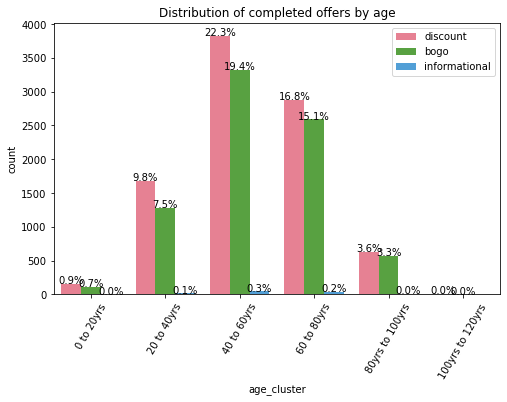

In [58]:
jx = plt.figure(figsize=(8, 5))
jx = sb.countplot(data = offer_success, x='age_cluster', hue='offer_type',
                 order =['0 to 20yrs', '20 to 40yrs', '40 to 60yrs', '60 to 80yrs', '80yrs to 100yrs',
                         '100yrs to 120yrs'],
                 palette=("husl"));

jx.legend(loc='upper right')
plt.xticks(rotation=60)
total = float(offer_success['age_cluster'].count())
for p in jx.patches:
    width = p.get_width()
    height = p.get_height()
    jx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
jx.set_title('Distribution of completed offers by age');

1. Discount offers is the offer type completed the by all age groups.

2. Customers between 40 and 60 yrs old complete the most offers

In [59]:
# No informational offers were completed by people over the age of 100
offer_success[offer_success['age_cluster']=='100yrs to 120yrs']['offer_type']

917      discount
4580     discount
4581         bogo
4582     discount
16695        bogo
16696    discount
45626    discount
48589    discount
Name: offer_type, dtype: object

3. **Total Amount Spent**

posx and posy should be finite values
posx and posy should be finite values


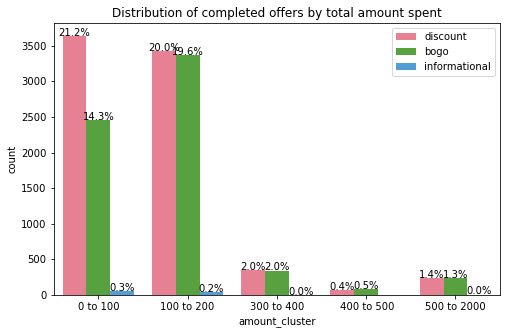

In [60]:
kx = plt.figure(figsize=(8, 5))
kx = sb.countplot(data = offer_success, x='amount_cluster', hue='offer_type',
                 order =['0 to 100', '100 to 200', '300 to 400', ' 400 to 500', '500 to 2000'],
                 palette="husl");

kx.legend(loc='upper right')
total = float(offer_success['amount_cluster'].count())
for p in kx.patches:
    width = p.get_width()
    height = p.get_height()
    kx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
kx.set_title('Distribution of completed offers by total amount spent');

Here, Customers that have spent the least(0 -100) prefer discount offers than BOGO offers
while in other clusters, there is no real distinction between discount and BOGO offers. 

Customers that have spent between 0 to 200 dollars are more interested in offers and have completed more of them.
                 

4. **Year Joined**

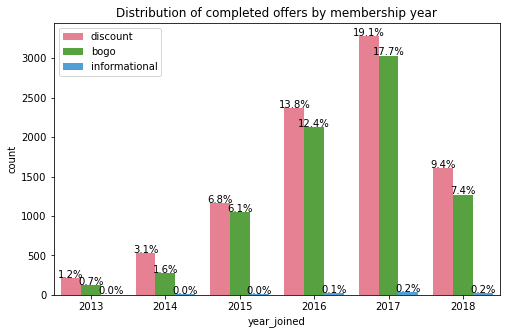

In [61]:
lx = plt.figure(figsize=(8, 5))
lx = sb.countplot(data = offer_success, x='year_joined', hue='offer_type',
                 #order =['2013', '2014', '2015', '2016', '2017', '2018'],
                 palette="husl");

lx.legend(loc='upper left')
total = float(offer_success['year_joined'].count())
for p in lx.patches:
    width = p.get_width()
    height = p.get_height()
    lx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
lx.set_title('Distribution of completed offers by membership year');

Customers that have joined more recently complete more offers than older customers

* **Informational Offers**

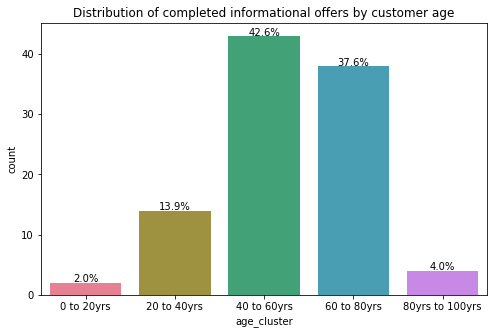

In [90]:
mx = plt.figure(figsize=(8, 5))
mx = sb.countplot(data = inform_success, x='age_cluster',
                 #order =['20k to 40k', '40k to 60k', '60k to 80k', '80k to 100k', '100k to 120k'],
                 palette="husl");

#mx.legend(loc='upper right')
total = float(inform_success['income_cluster'].count())
for p in mx.patches:
    width = p.get_width()
    height = p.get_height()
    mx.text(p.get_x() + p.get_width()/2.,height+.1, '{:1.1f}%'.format((height/total)*100), ha='center')
mx.set_title('Distribution of completed informational offers by customer age');

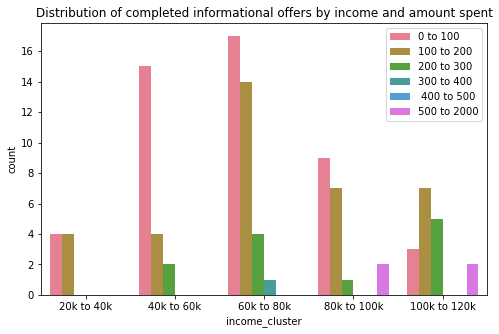

In [63]:
nx = plt.figure(figsize=(8, 5))
nx = sb.countplot(data = inform_success, x='income_cluster', hue='amount_cluster',
                 order =['20k to 40k', '40k to 60k', '60k to 80k', '80k to 100k', '100k to 120k'],
                  palette="husl");

nx.legend(loc='upper right')
total = float(inform_success['income_cluster'].count())
for p in nx.patches:
    width = p.get_width()
    height = p.get_height()
    #nx.text(p.get_x() + p.get_width()/2.,height+.1, '{:1.1f}%'.format((height/total)*100), ha='center')
nx.set_title('Distribution of completed informational offers by income and amount spent');

For informational offers as well, Customers earning between **60 and 80k**, customers between **40 and 60 years old** and customers that have 
spent between 0 - 100 dollars responded best to the informational offer

###  Offer Summary
* For all offer types, Customers that fall into the categories below completed more offers than others. 
* Income: customers that earned between 60k and 80k 
* Age: customers who were between 40 and 60 years old
* Amount spent : Customers who have spent between 0 to 200 dollars
* Year Joined : Relatively newer members complete more offers than cutomers who have been in the program for longer 



### Machine learning Model
* Create a machine learning model that predicts if a customer will successfuly complete an offer

* The output variable in this case is **'offer_successful'**

In [64]:
# Drop the values not needed for ML model
ml_df = df_grouped.drop(['became_member_on', 'customer_id', 'offer_type', 
                         'event', 'transaction', 'month_joined', 'inform_amount', 'inform_time'], axis=1)

ml_df['age'] = ml_df['age'].astype(float)
ml_df['year_joined'] = ml_df['year_joined'].astype(str)

In [65]:
# Create a function that encodes the categorical columns and also creates dummies

def encoder(df):
    '''
    This function encodes the categorical columns and creates a dummy column for the gender column
    
    INPUT : dataframe for the ML model
    
    OUTPUT: dataframe with encoded  and dummy columns 
    
    '''
    
    for col in df[['age_cluster', 'income_cluster', 'offer_id', 'year_joined', 'amount_cluster']].columns:

        labels = df[col].astype('category').cat.categories.tolist()
    
        replace_map = {col : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    
        df.replace(replace_map, inplace=True)
        
        print(replace_map)
    ml_dummies = pd.get_dummies(df['gender'])

    df = pd.concat([df, ml_dummies], axis=1)
    
    return df 

In [66]:
model_df = encoder(ml_df)
model_df.head()

{'age_cluster': {'0 to 20yrs': 1, '100yrs to 120yrs': 2, '20 to 40yrs': 3, '40 to 60yrs': 4, '60 to 80yrs': 5, '80yrs to 100yrs': 6}}
{'income_cluster': {'100k to 120k': 1, '20k to 40k': 2, '40k to 60k': 3, '60k to 80k': 4, '80k to 100k': 5}}
{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}
{'year_joined': {'2013': 1, '2014': 2, '2015': 3, '2016': 4, '2017': 5, '2018': 6}}
{'amount_cluster': {'0 to 100': 1, '100 to 200': 2, '200 to 300': 3, '300 to 400': 4, ' 400 to 500': 5, '500 to 2000': 6}}


,amount_spent,offer_id,gender,age,income,year_joined,time_days,offer completed,offer received,offer viewed,...,offer completed time,offer end time,viewed on time,completed_on_time,inform_complete,offer_successful,amount_cluster,F,M,O
0,127.6,3,M,33.0,72000.0,5,24.0,1,1,0,...,24.00,31.0,0.0,0.0,0.0,0.0,2,0,1,0
1,127.6,4,M,33.0,72000.0,5,15.5,0,1,1,...,18.00,18.0,1.0,0.0,0.0,0.0,2,0,1,0
2,127.6,6,M,33.0,72000.0,5,8.0,0,1,1,...,10.00,10.0,1.0,0.0,0.0,0.0,2,0,1,0
3,127.6,9,M,33.0,72000.0,5,19.0,1,1,1,...,17.25,22.0,1.0,0.0,0.0,0.0,2,0,1,0
4,127.6,10,M,33.0,72000.0,5,22.5,1,1,1,...,22.00,31.0,1.0,0.0,0.0,0.0,2,0,1,0


**A correlation matrix is used to decide on the feature variables. It helps avoid Multi-collinearity and overfitting**


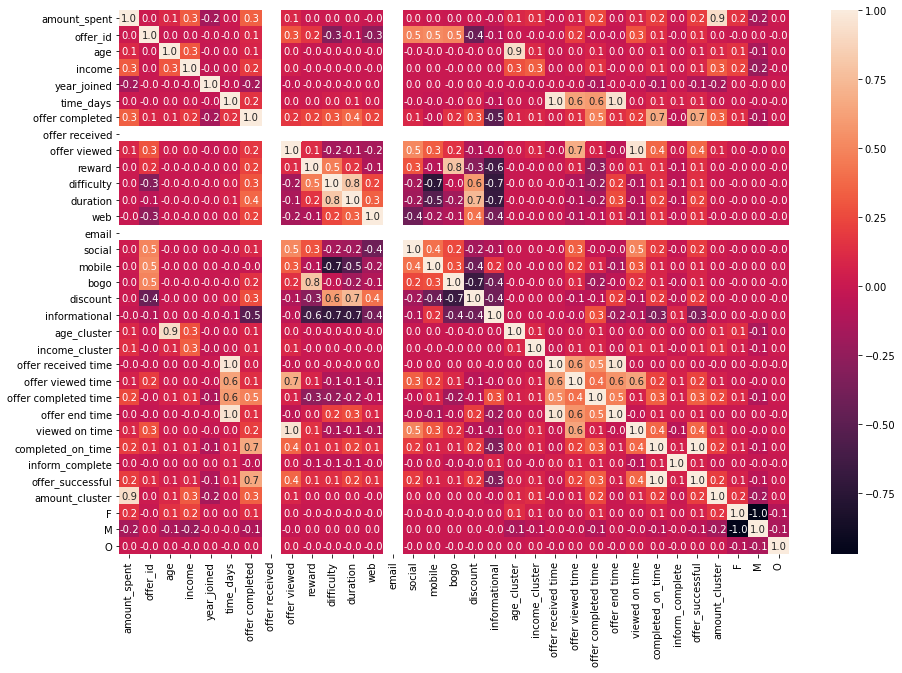

In [67]:
fig = plt.figure(figsize=(15, 10))
fig.subplots(1, 1)
sb.heatmap(model_df.corr(), annot=True, fmt='.1f');

In [68]:
# drop features with high multicollinearity and high colleration with the offer_successful column
model_df = model_df.drop(['age', 'offer end time', 'completed_on_time',
                         'viewed on time', 'inform_complete', 'offer viewed time',
                         'offer received time', 'time_days', 'income', 'offer completed',
                         'offer received', 'offer viewed', 'offer completed time', 'amount_spent', 
                          'gender'], axis=1)

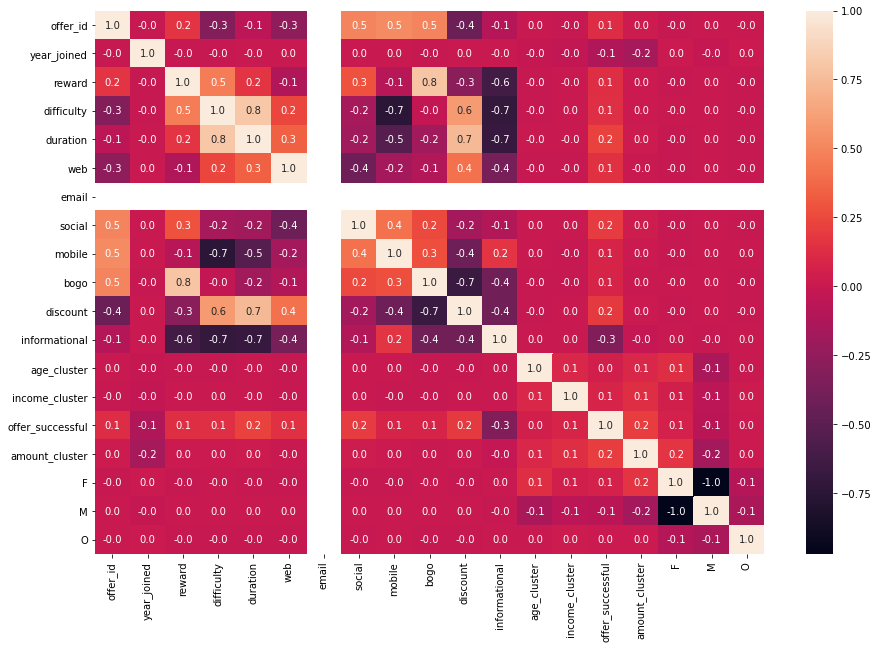

In [69]:
fig = plt.figure(figsize=(15, 10))
fig.subplots(1, 1)
sb.heatmap(model_df.corr(), annot=True, fmt='.1f');

In [70]:
model_df.columns

Index(['offer_id', 'year_joined', 'reward', 'difficulty', 'duration', 'web',
       'email', 'social', 'mobile', 'bogo', 'discount', 'informational',
       'age_cluster', 'income_cluster', 'offer_successful', 'amount_cluster',
       'F', 'M', 'O'],
      dtype='object')

Collinearity has been reduced to "little". Features like reward and difficulty are correlated with the offer types. 

We have chosen to leave this in the feature column as they do not reduce the strength of the machine learning models

#### 1. Logistic Regression 

* Here are a scaler was applied on the X columns

In [71]:
def logisticreg(df, filepath):
    """
    This function runs logistic regression on the dataframe. 
    
    INPUT:
    df - cleaned dataframe for machine learning
    filepath - directory to save the model 
    
    OUTPUT:
    Classification report, Model Accuracy, Confusion Matrix
    
    """
    
    X = df.drop(['offer_successful'], axis=1).values
    Y = df['offer_successful'].values
    X_columns = df.drop(['offer_successful'], axis=1).columns

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

        
    clf = LogisticRegression(random_state=42)
    
    
    parameters = {

                'penalty': ['l1', 'l2'],
                'C': [1, 10, 100],
                'solver':['liblinear']
                     }
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=2, verbose=3)
    cv.fit(X_train, y_train)
    
    model = clf
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)
    model_f1_score = f1_score(y_test, pred)
    class_report = classification_report(y_test, pred)
    auc_score = roc_auc_score(y_test, pred)
    
    # feature importance
    smf = SelectFromModel(model, prefit=True)
    feature_importances = smf.get_support()
    feature_name = X_columns[feature_importances]
    feature_name
    
    matrix = confusion_matrix(y_test, pred)
    
    print(class_report)
    
    return model_f1_score, feature_name, auc_score, matrix

In [72]:
lr_f1_score, best_features, auc_score, matrix = logisticreg(model_df, '/Users/doyindav/Desktop/data science/starbucks_capstone/models/lr_model')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] C=1, penalty=l1, solver=liblinear ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1, penalty=l1, solver=liblinear, score=0.742, total=   0.8s
[CV] C=1, penalty=l1, solver=liblinear ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ... C=1, penalty=l1, solver=liblinear, score=0.741, total=   0.6s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.742, total=   0.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.741, total=   0.1s
[CV] C=10, penalty=l1, solver=liblinear ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] .. C=10, penalty=l1, solver=liblinear, score=0.742, total=   2.4s
[CV] C=10, penalty=l1, solver=liblinear ..............................
[CV] .. C=10, penalty=l1, solver=liblinear, score=0.741, total=   1.5s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.742, total=   0.1s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.741, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.742, total=   6.0s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.741, total=   3.9s
[CV] C=100, penalty=l2, solver=liblinear .............................
[CV] . C=100, penalty=l2, solver=liblinear, score=0.742, total=   0.1s
[CV] C=100, penalty=l2, solver=liblinear .............................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   15.7s finished


              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83      9552
         1.0       0.64      0.41      0.50      4254

    accuracy                           0.75     13806
   macro avg       0.70      0.65      0.67     13806
weighted avg       0.73      0.75      0.73     13806



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

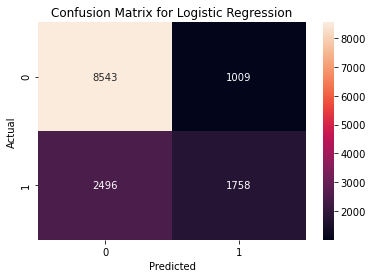

In [73]:
# plot the confusion matrix for logistic Regression
matrix_df = pd.DataFrame(matrix, range(2), range(2))
    
qx = sb.heatmap(matrix_df, annot=True, fmt='.4g')
plt.xlabel('Predicted');
plt.ylabel('Actual')
qx.set_title('Confusion Matrix for Logistic Regression')

In [74]:
print(round(lr_f1_score, 2)), print(round(auc_score, 2))

0.5
0.65


(None, None)

In [75]:
best_features

Index(['year_joined', 'difficulty', 'duration', 'social', 'bogo', 'discount',
       'informational', 'amount_cluster'],
      dtype='object')

### Random Forest Classifier

In [76]:
def random_forest(df, filepath):
    X = df.drop(['offer_successful'], axis=1).values
    Y = df['offer_successful'].values
    X_columns = df.drop(['offer_successful'], axis=1).columns

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    

        
    clf = RandomForestClassifier(random_state=42)
    
    
    parameters = {

                'clf__estimator__n_estimators': [50, 100, 200],
                'clf__estimator__min_samples_split': [2, 4, 6],
        
                     }
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=2, verbose=3)
    
    model = clf
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)
    model_f1_score = f1_score(y_test, pred)
    class_report = classification_report(y_test, pred)
    matrix = confusion_matrix(y_test, pred)
    auc_score = roc_auc_score(y_test, pred)
   
    # feature importance
    feature_importances = pd.DataFrame(model.feature_importances_, index= X_columns,
                                      columns=['importance']).sort_values('importance', ascending=False)
   
    
    matrix = confusion_matrix(y_test, pred)
    
    print(class_report)
    
    return model_f1_score, feature_importances, auc_score, matrix 

In [77]:
rf_f1_score, rf_best_features, rf_auc_score, rf_matrix = random_forest(model_df, '/Users/doyindav/Desktop/data science/starbucks_capstone/models/rf_model')

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      9552
         1.0       0.59      0.52      0.55      4254

    accuracy                           0.74     13806
   macro avg       0.69      0.68      0.68     13806
weighted avg       0.73      0.74      0.74     13806



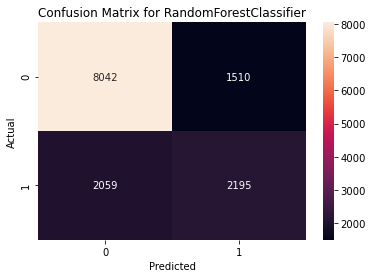

In [78]:
randomclass_matrix = pd.DataFrame(rf_matrix, range(2), range(2))
    
qx = sb.heatmap(randomclass_matrix, annot=True, fmt='.4g')
plt.xlabel('Predicted');
plt.ylabel('Actual')
qx.set_title('Confusion Matrix for RandomForestClassifier');

<Figure size 720x576 with 0 Axes>

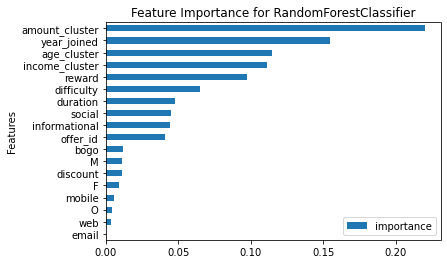

In [79]:
rx = plt.figure(figsize=(10,8));
rx =rf_best_features.plot(kind='barh')
rx.invert_yaxis();
rx.set_title('Feature Importance for RandomForestClassifier');
rx.set_ylabel('Features');

In [80]:
print('This model has an f1_score of {}'.format(round(rf_f1_score, 2)))
print('This model has an roc_auc score of {}'.format(round(rf_auc_score, 2)))

This model has an f1_score of 0.55
This model has an roc_auc score of 0.68


### Gradient Boosting Classifier

In [81]:
def gradboost(df, filepath):
    X = df.drop(['offer_successful'], axis=1).values
    Y = df['offer_successful'].values
    X_columns = df.drop(['offer_successful'], axis=1).columns

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    

        
    clf = GradientBoostingClassifier(random_state=42)
    
    
    parameters = {

                'clf__estimator__learning_rate': [0.1, 0.5, 1],
                'clf__estimator__min_samples_leaf': [10, 20, 40 , 60]
                
        
                     }
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=2, verbose=3)
    
    model = clf
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)
    model_f1_score = f1_score(y_test, pred)
    class_report = classification_report(y_test, pred)
    matrix = confusion_matrix(y_test, pred)
    auc_score = roc_auc_score(y_test, pred)
    
    # feature importance
    feature_importances = pd.DataFrame(model.feature_importances_, index= X_columns,
                                      columns=['importance']).sort_values('importance', ascending=False)
    
   
    print(class_report)
    
    return model_f1_score, feature_importances, auc_score, matrix 

In [82]:
gb_f1_score, gb_best_features, gb_auc_score, gb_matrix = gradboost(model_df, '/Users/doyindav/Desktop/data science/starbucks_capstone/models/gb_model')

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      9552
         1.0       0.63      0.52      0.57      4254

    accuracy                           0.76     13806
   macro avg       0.72      0.69      0.70     13806
weighted avg       0.75      0.76      0.75     13806



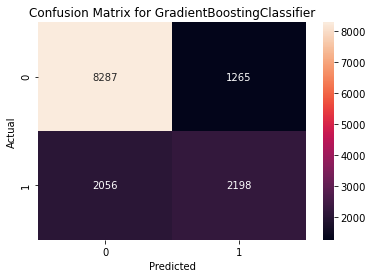

In [83]:
gb_matrix_df = pd.DataFrame(gb_matrix, range(2), range(2))
    
qx = sb.heatmap(gb_matrix, annot=True, fmt='.4g')
plt.xlabel('Predicted');
plt.ylabel('Actual')
qx.set_title('Confusion Matrix for GradientBoostingClassifier');

<Figure size 720x576 with 0 Axes>

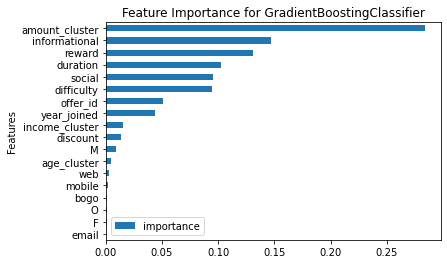

In [84]:
sx = plt.figure(figsize=(10,8));
sx =gb_best_features.plot(kind='barh')
sx.invert_yaxis();
sx.set_title('Feature Importance for GradientBoostingClassifier');
sx.set_ylabel('Features');

In [85]:
print('This model has an accuracy of 0.76')
print('This model has an f1_score of {}'.format(round(gb_f1_score, 2)))
print('This model has an roc_auc score of {}'.format(round(gb_auc_score, 2)))

This model has an accuracy of 0.76
This model has an f1_score of 0.57
This model has an roc_auc score of 0.69


### Machine learning method Summary

The best method is the GradientBoostingClassifier. It has the highest of the metric scores and so is our best performing model.

* accuracy = 0.76
* f1_score = 0.57
* roc_auc_score = 0.69

In [86]:
# test 
test_model = model_df.drop(['bogo', 'email', 'web', 'M', 'F', 'O', 'age_cluster'], axis=1);


In [87]:
test_f1_score, test_best_features, test_auc_score, test_matrix= gradboost(test_model, '/Users/doyindav/Desktop/test_model')

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      9552
         1.0       0.63      0.53      0.58      4254

    accuracy                           0.76     13806
   macro avg       0.72      0.70      0.71     13806
weighted avg       0.75      0.76      0.75     13806



In [88]:
test_f1_score, test_auc_score

(0.5780730897009966, 0.6972953920991889)

## Conclusion

In carrying out this task, two methods were used. The first one was an analytical analysis of the available data
to determine what demographic of customers completed more offers. The second technique invloved using 
a machine learning algorithm to predict if customers will complete offers. 

* Customers that earned between 60k and 80k completed more offers than other income groups.
* Customers who were between 40 and 60 years old completed more offers than other age groups.
* Customers who have spent between 0 to 200 dollars completed more offers than other customers.
* Relatively newer members complete more offers than cutomers who have been in the program for longer


* The total amount a customer spends is essential in predicting if a customer will complete an offer.
* Offer characteristics like reward, difficulty and duration are important in determining whether a customer completes an offer.
* The year a customer joined the program and their income is also key in determining the success of an offer